## Visualizing Attention



In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image
from util import get_loader, decode_captions, attention_visualization

%matplotlib inline

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

In [4]:
vocab_path ='data/vocab.pkl'
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [5]:
#Set parameters as Training
embed_dim = 512
hidden_dim = 512
annot_dim = 512
annot_num = 196
num_layers = 1

encoder_path = 'trained_models/encoder-2-3000.ckpt'
decoder_path = 'trained_models/decoder-2-3000.ckpt'

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build models
encoder = EncoderCNN(embed_dim).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_dim, annot_dim, annot_num, hidden_dim, len(vocab), num_layers).eval()
encoder = encoder.to(device)
decoder = decoder.to(device)

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

In [7]:
root = 'cocoData/2014_images/val2014/'
files = None
batch_size = 1
shuffle = False
num_workers = 2


In [8]:
dataloader = get_loader(batch_size=batch_size, files=files, 
                        num_workers=num_workers, root=root,
                        transform=transform, shuffle=shuffle)

In [9]:
names = []
captions = []
alphas = []
for i, (image, name) in enumerate(dataloader):
    image = image.cuda()
    fea = encoder(image)
    ids, weights = decoder.sample(fea)
    names.append(name)
    captions.append(ids)
    alphas.append(weights)
    if (i+1)%100 == 0:
        break

['a', 'bus', 'is', 'parked', 'in', 'front', 'of', 'a', 'building', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']


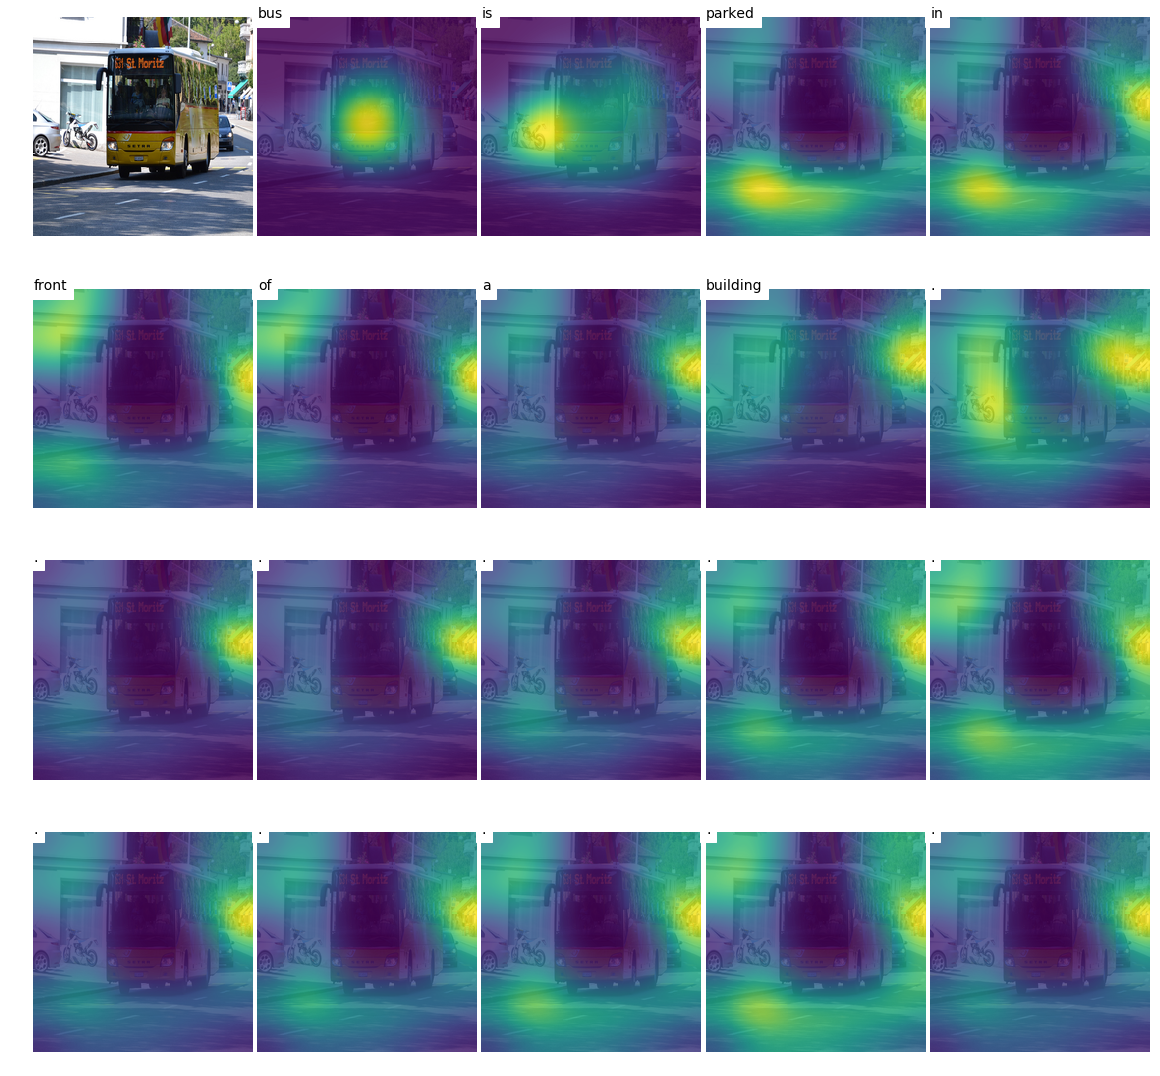

In [10]:
fig=plt.figure(figsize=(20, 20))
idx = 73

plt.subplots_adjust(wspace=0.02, hspace=0)

alps = torch.cat(alphas[idx][1:], 0)
cap = decode_captions(captions[idx].data.cpu().view(1, -1), vocab.idx2word)[0]
print(cap)
attention_visualization(root, names[idx][0], cap, alps.data.cpu())


['a', 'man', 'holding', 'a', 'red', 'umbrella', 'in', 'front', 'of', 'a', 'street', 'sign', '.', '.', '.', '.', '.', '.', '.', '.']


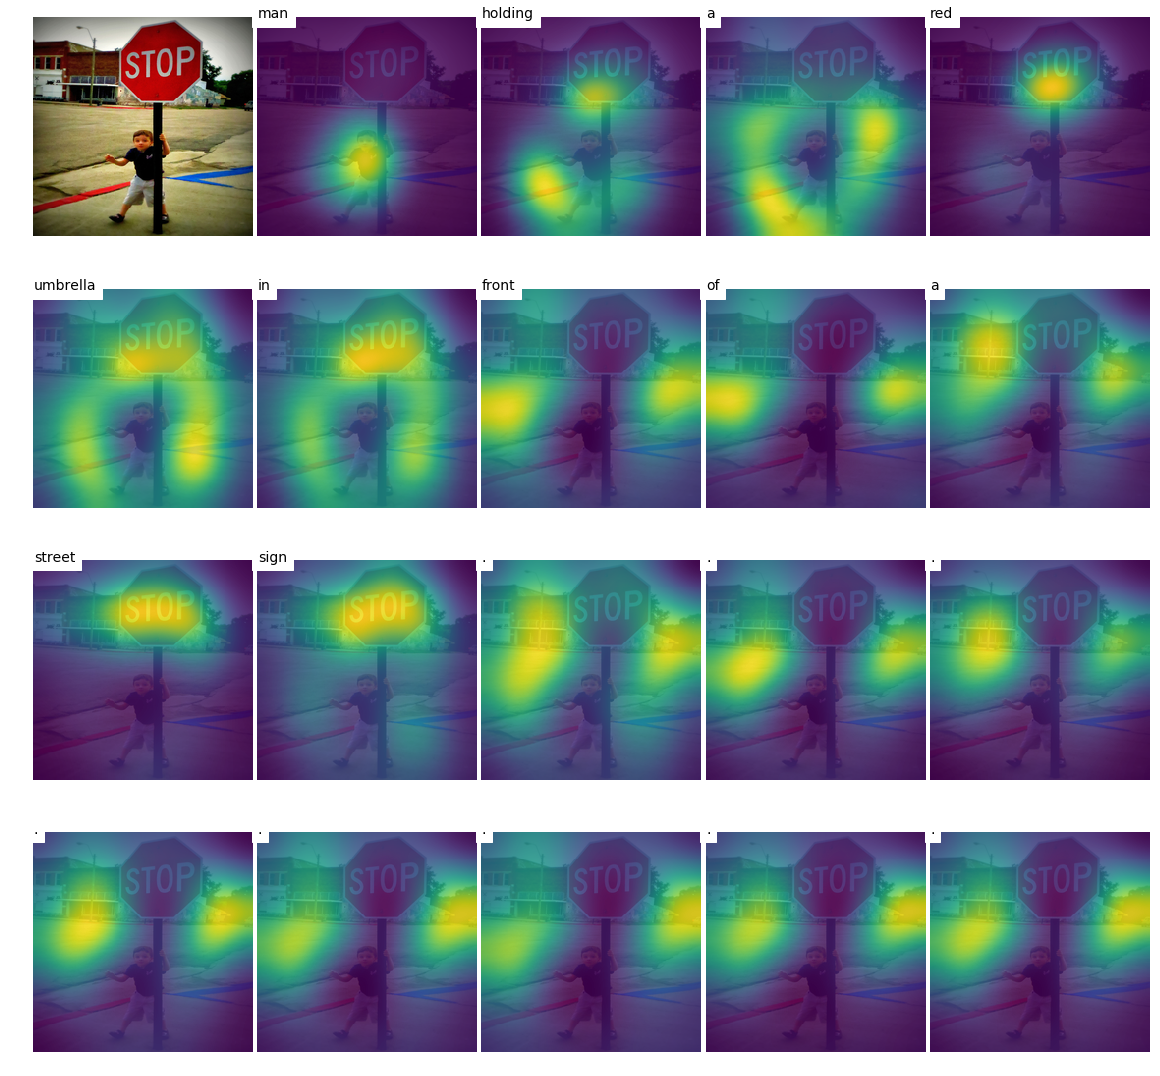

In [11]:
fig=plt.figure(figsize=(20, 20))
plt.axis('off')

plt.subplots_adjust(wspace=0.02, hspace=0)
idx = 62
alps = torch.cat(alphas[idx][1:], 0)
cap = decode_captions(captions[idx].data.cpu().view(1, -1), vocab.idx2word)[0]
print(cap)
attention_visualization(root, names[idx][0], cap, alps.data.cpu())
